In [75]:
#Imports

import numpy as np
import os
import shutil
import openpyxl as oxl
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from copy import deepcopy

from datetime import datetime

from collections import deque

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
from PIL import Image
import cv2

import json
import xml.etree.ElementTree as ET

import collections

# This is needed if the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

#imports from object-detection module
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# This is needed to display the images.
%matplotlib inline

## Preparing WM logs using keyPoint detection and YOLO LSTM

### Method Definitions

In [32]:
def draw_patch_keypoints(image, patch_keypoints, validKeypoints = []):
    colors = [[255, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0], [153, 255, 255]]
    circle_radius=5

    for i, joint_keypoint in enumerate(patch_keypoints):
        x, y = joint_keypoint
        
        if x == 0 or y == 0:
            continue
            
        if len(validKeypoints) > 1 and joint_keypoint not in validKeypoints:
            continue

        cv2.circle(image, (x, y), circle_radius, colors[i], -1)

    return image

In [33]:
def draw_fittedCurves_for1setOfKeypoints(image, setof_keypoints, esimatorFunction, colorNb=0):
    #colors = [[204, 0, 204], [255, 255, 51], [255, 51, 255], [153, 51, 255], [255, 102, 255], [178, 102, 255]]
    colors = [[255, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0], [153, 255, 255]]
    
    #pts = [[p[0], int(esimatorFunction(p[0]))] for p in setof_keypoints if(p[0] > 0 and p[1]>0)]
    pts = [[indx, int(esimatorFunction(indx))] for indx in range(10, 600, 50)]
    pts_np = np.array(pts, np.int32)
    pts_np = pts_np.reshape((-1,1,2))
    cv2.polylines(image,[pts_np],False,colors[colorNb])

    return image

In [34]:
def draw_box(image, box):
    colors = [(0, 255, 0), (0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0),(0, 255, 255)]
    labels=["Tooth", "Toothline", "BucketBB", "MatInside", "WearArea"]
    image_h, image_w, _ = image.shape
    
    if len(box) > 3:
        xmin = int(box[0] * image_w)
        xmax = int(box[1] * image_w)
        ymin = int(box[2] * image_h)
        ymax = int(box[3] * image_h)
        label, score = box[4:6]
        #print(str(xmin) + '  ' + str(xmax) + '  '  + str(ymin) + '  ' + str(ymax) + '  ' + label)
        
        #add tooth length (from box) as a field
        box.append(ymax-ymin)

        if xmin < 0: xmin = 0
        if ymin < 0: ymin = 0

        color = colors[labels.index(label)]
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)

        font_increase = 1.
        cv2.putText(
            image,
            str(score),
            (xmin, ymin - 6),
            cv2.FONT_HERSHEY_SIMPLEX,
            8e-4 * image_h * font_increase,
            color, 2)

    return image

In [35]:
def draw_all_boxes(image, boxesDict):
    for key in boxesDict.keys():
        if 'keypoints' not in key and key not in ['nbOfDetectedTeeth','fileName', 'fittedCurves', '2ndDerivFittedCurves']:
            image = draw_box(image, boxesDict[key])
            
    return image

In [36]:
def draw_all_keypoints_boxes_andCurves(image, resultsDict, numberOfTeeth, drawOnlyValidated=False, numberOflandmarksIncludingToothTip = 5):

    image = inImage
    esimatorFunctions = resultsDict['fittedCurves']
    
    for toothNb in range(numberOfTeeth):
        toothKeyPointKey = 'keypointsForTooth_' + str(toothNb + 1)
        
        if toothKeyPointKey in resultsDict:
            
            if drawOnlyValidated:
                image = draw_patch_keypoints(image, resultsDict[toothKeyPointKey], resultsDict['validatedKeypoints'])
            else:
                image = draw_patch_keypoints(image, resultsDict[toothKeyPointKey], [])

        
    for keypointNb in range(numberOflandmarksIncludingToothTip):
        toothKeyPointKey = 'keypoints_' + str(keypointNb + 1)
        
        if toothKeyPointKey in esimatorFunctions:
            image = draw_fittedCurves_for1setOfKeypoints(image, resultsDict[toothKeyPointKey], esimatorFunctions[toothKeyPointKey], colorNb=keypointNb)

        
    if not drawOnlyValidated:
        draw_all_boxes(image, resultsDict)

    return image

In [37]:
def dimg(framesDir, fileName, teethBoxes, keypoints):
    inImage = cv2.imread(framesDir + fileName.replace('.json','.png'))
    outImage = draw_all_keypoints(inImage, data[0], circle_radius=3)
    outImage = draw_boxes(outImage, data[1]) 
    plt.imshow(outImage)
    plt.show()

In [38]:
def getFrameTime(resultsDict, resultsKey, fileName):
    for timeKey in resultsDict[resultsKey].keys():
        if fileName in resultsDict[resultsKey][timeKey]['fileName']:
            print(timeKey)
            print(resultsDict[resultsKey][timeKey]['fileName'])
            print('\n')
            return timeKey
    
    print('could not find the requested file')
    return None

In [39]:
def loadResults(resultsDir, rawFramesDir=None):
    #Load JSON prediciton results from disc into dict
    resultsDirectories = []


    
    #for resultsDir in resultsDirectories:
    resultsDir = wmsDir
    resultKey = resultsDir.split('/')[-3]

    
    


    resultsDic = {}

    datetimemask = "%Y.%m.%d %H.%M.%S"
    
    resultsDic[resultKey] = {}

    zeroTimeRef = None

    for fileName in sorted(os.listdir(resultsDir)):
        if fileName and '.json' in fileName:

            fileNameAr = fileName[:len(fileName)-5].split('_')
            time = fileNameAr[1] + ' ' + fileNameAr[2]
            dateTime = datetime.strptime(time, datetimemask)

            curHourSince = 0

            if zeroTimeRef == None:
                zeroTimeRef = dateTime
            else:
                timeDif = dateTime - zeroTimeRef
                totalSeconds = timeDif.seconds
                totalDays = timeDif.days
                curHourSince = totalSeconds/3600 + totalDays*24



            with open(resultsDir + fileName, 'r') as fjson:
                data = tuple(json.load(fjson))
                #print(fileName)

                resultsDic[resultKey][curHourSince] = {}      
                resultsDic[resultKey][curHourSince]['time'] = time
                resultsDic[resultKey][curHourSince]['keypoints'] = data[0]
                resultsDic[resultKey][curHourSince]['teeth'] = data[1]
                resultsDic[resultKey][curHourSince]['buckets'] = data[2]
                resultsDic[resultKey][curHourSince]['nbOfDetectedTeeth'] = len(data[1])
                resultsDic[resultKey][curHourSince]['fileName'] = resultsDir + fileName.replace('.json', '.png')
                


            #print(resultsDic)
            #dimg(rawFramesDir, fileName, data)
            #break



    print("loaded the results for  " + str(len(resultsDic[resultKey])) + "   frames. For key: " + resultKey)
    return resultsDic

In [40]:
def parseResults(resultsDic, numberOfTeeth, numberOflandmarksIncludingToothTip = 5):
    paresedResultsDict = {}
    
    for resKey in resultsDic.keys():
        paresedResultsDict[resKey] = {}
        
        for time in resultsDic[resKey].keys():
            paresedResultsDict[resKey][time] = {}
            
            paresedResultsDict[resKey][time]['nbOfDetectedTeeth'] = resultsDic[resKey][time]['nbOfDetectedTeeth'] 
            paresedResultsDict[resKey][time]['fileName'] = resultsDic[resKey][time]['fileName']
            
            #parse the bucket objects
            for obj in resultsDic[resKey][time]['buckets']:
                paresedResultsDict[resKey][time][obj[4]] = obj
                
            #parse the teeth 
            toothNb = 1
            for obj in sorted(resultsDic[resKey][time]['teeth'], key=lambda rv: rv[0]):
                paresedResultsDict[resKey][time]['Tooth_' + str(toothNb)] = obj
                toothNb += 1
                
            toothNb = 1
            for keypointsSet in sorted(resultsDic[resKey][time]['keypoints'], key=lambda kv: kv[0]):           
                paresedResultsDict[resKey][time]['keypointsForTooth_' + str(toothNb)] = keypointsSet
                toothNb += 1
                
                
            for keypointsNb in range(numberOflandmarksIncludingToothTip):       
                paresedResultsDict[resKey][time]['keypoints_' + str(keypointsNb + 1)] = [keypointsSet[keypointsNb] for keypointsSet in sorted(resultsDic[resKey][time]['keypoints'], key=lambda kv: kv[0])]
            
                
    return paresedResultsDict

In [41]:
def filterParsedResults(parsedResultsDic, rejectedResultsDir, numberOfTeeth):
    filteredResults = deepcopy(parsedResultsDic)
    
    for resKey in parsedResultsDic.keys():
        deletedCount = 0
        for time in parsedResultsDic[resKey].keys():
            
            filePath = paresedResultsDict[resKey][time]['fileName']
            fileName = filePath.split('/')[-1]
            
            #reject1 not enough teeth boxes detected.
            if paresedResultsDict[resKey][time]['nbOfDetectedTeeth']  < numberOfTeeth:
                shutil.copy(filePath, rejectedResultsDir)
                print('\nrejected:\n' + str(filePath) + '\nbecause not enough teeth (tips) were detected.')
                del filteredResults[resKey][time]
                deletedCount += 1


            '''
            #reject2 no wearArea detected
            elif 'WearArea' not in paresedResultsDict[resKey][time].keys():
                shutil.copy(filePath, rejectedResultsDir)
                print('\nrejected:\n' + str(filePath) + '\nbecause wearArea was not detected.')
                del filteredResults[resKey][time]
                deletedCount += 1
            '''

                
        print('\nfor results set: ' + resKey + '  rejected ' + str(deletedCount) + ' logs from the parsedResultsDic which were not copied into filteredResults.')
        
        return filteredResults

In [42]:
def fitCurve2keypoints(keypoints, numberOfTeeth):
    numberOflandmarksIncludingToothTip = 5
    degreeOfPolyn = 2
    minNumberOflandmarksNeededToFitCurve = 3
    
    estimatedFunctions = {}
    
    for landmarkNb in range(numberOflandmarksIncludingToothTip):
        landmarkKey = 'keypoints_' + str(landmarkNb + 1)
        
        x = np.ndarray(shape=(1,))
        y = np.ndarray(shape=(1,))
        
        for point in keypoints[landmarkKey]:
            if(point[0] > 0 and point[1] > 0):
                x = np.vstack([x, point[0]])
                y = np.vstack([y, point[1]])
            
        x = x[1:,]
        y = y[1:,]
        x = x.reshape(-1)
        y = y.reshape(-1)
        
        if len(x) >= minNumberOflandmarksNeededToFitCurve and len(y) >= minNumberOflandmarksNeededToFitCurve:
            z = np.polyfit(x, y, degreeOfPolyn)

            estimatedFunctions[landmarkKey] = np.poly1d(z)
        
    
    return estimatedFunctions

In [43]:
def get2ndDerivativeOfCurves(fittC):
    secondDervs = {}
    for key in fittC.keys():
        secondDervs[key] = fittC[key].deriv().deriv().c[0]
        
    return secondDervs

In [44]:
def removeBadCurvesAndKeyPoints(filteredResultsDict, path2saveCurves, rejectedPredsDir, curvDerivTreshDic):
    
    cleanedUpResultsDict = deepcopy(filteredResultsDict)
    
    for resKey in filteredResultsDict.keys():
        deletedCount = 0
        for time in filteredResultsDict[resKey].keys():
            
            fileName = filteredResultsDict[resKey][time]['fileName'].split('/')[-1]
            filePath = path2saveCurves + fileName
            
            
            for keypointsKey in curvDerivTreshDic.keys():
                #reject1 no curve calculated for this keypoint type (because there was less than 2 of them)
                if keypointsKey not in filteredResultsDict[resKey][time]['fittedCurves']:
                    del(cleanedUpResultsDict[resKey][time][keypointsKey])

                    #shutil.copy(filePath, rejectedPredsDir)
                    print('\nrejected:\n' + str(filePath) + '\nbecause no curve was fitted for this keypoint type.')
                    deletedCount += 1
                    
                    
            #reject2 2nd derivative of fitted curve for this keypoint type doesnt satisfy thresholds        
            for keypointsKey in filteredResultsDict[resKey][time]['2ndDerivFittedCurves'].keys():
                derivative = filteredResultsDict[resKey][time]['2ndDerivFittedCurves'][keypointsKey]
                
                if derivative < curvDerivTreshDic[keypointsKey][0]\
                or derivative > curvDerivTreshDic[keypointsKey][1]:
                    
                    if keypointsKey in cleanedUpResultsDict[resKey][time]:
                        del(cleanedUpResultsDict[resKey][time][keypointsKey])
                        del(cleanedUpResultsDict[resKey][time]['2ndDerivFittedCurves'][keypointsKey])
                        del(cleanedUpResultsDict[resKey][time]['fittedCurves'][keypointsKey])

                        shutil.copy(filePath, rejectedPredsDir)
                        print('\nrejected:\n' + str(filePath) + '\nbecause derivative of fitted curve didnt fit the criteria.')
                        deletedCount += 1
                        
                        
                        
            #after the clean up, count all the valid (i.e remaining) keypoints
            cleanedUpResultsDict[resKey][time]['validatedKeypoints'] = []
            
            for keypointsKey in cleanedUpResultsDict[resKey][time]['2ndDerivFittedCurves'].keys():
                for keypoint in cleanedUpResultsDict[resKey][time][keypointsKey]:
                    cleanedUpResultsDict[resKey][time]['validatedKeypoints'].append(keypoint)
            


                
        print('\nfor results set: ' + resKey + '  rejected ' + str(deletedCount) + ' keypoints from the filteredResults which were not copied into cleanedUpResultsDict.')
        
        return cleanedUpResultsDict

In [45]:
def filterCleanedUpResults(cleanedUpResultsDict, rejectedResultsDir, numberOfTeeth):
    finalResultsDict = deepcopy(cleanedUpResultsDict)
    
    for resKey in cleanedUpResultsDict.keys():
        deletedCount = 0
        for time in cleanedUpResultsDict[resKey].keys():
            
            filePath = cleanedUpResultsDict[resKey][time]['fileName']
            fileName = filePath.split('/')[-1]
            
            #reject1 not enough teeth boxes + tips detected.
            if 'keypoints_1' not in cleanedUpResultsDict[resKey][time] or\
            len([x for x in cleanedUpResultsDict[resKey][time]['keypoints_1'] if (x[0] == 0 and x[1] == 0)]) > 0:
                
                shutil.copy(filePath, rejectedResultsDir)
                print('\nrejected:\n' + str(filePath) + '\nbecause not enough toothTips were detected.')
                del finalResultsDict[resKey][time]
                deletedCount += 1

                
        print('\nfor results set: ' + resKey + '  rejected ' + str(deletedCount) + ' logs from the cleanedUpResultsDict which were not copied into finalResultsDict.')
        
        return finalResultsDict

### Loading the json prediction results into resultsDic, parsing, and filtering

In [46]:
#Load JSON prediciton results from disc into dict
wmsDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/'

rawFramesDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/frame3Chan/'

rejectedPredsDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/rejected_notAllTeeth'


resultsDict = loadResults(wmsDir)

paresedResultsDict = parseResults(resultsDict, numberOfTeeth= 6)

filteredResultsDict = filterParsedResults(paresedResultsDict, rejectedPredsDir, numberOfTeeth= 6)

loaded the results for  366   frames. For key: wmdlLogs_Pinto

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.19_20.43.54.png
because not enough teeth (tips) were detected.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.20_04.31.19.png
because not enough teeth (tips) were detected.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.19_04.37.56.png
because not enough teeth (tips) were detected.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.20_02.29.12.png
because not enough teeth (tips) w

In [47]:
# For all frames: Fit curves to all landmarks, calculate curve derives, save the vis img, save res in filteredDict.
path2saveCurves = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/curves/'

numberOfTeeth = 6

for resKey in filteredResultsDict.keys():
    for time in filteredResultsDict[resKey].keys():
        fileName = filteredResultsDict[resKey][time]['fileName'].split('/')[-1]
        
        fittC = fitCurve2keypoints(filteredResultsDict[resKey][time], numberOfTeeth)
        
        filteredResultsDict[resKey][time]['fittedCurves'] = fittC
        filteredResultsDict[resKey][time]['2ndDerivFittedCurves'] = get2ndDerivativeOfCurves(fittC)
        
        inImage = cv2.imread(rawFramesDir + fileName)

        outImage =  draw_all_keypoints_boxes_andCurves(inImage, filteredResultsDict[resKey][time], numberOfTeeth)

        cv2.imwrite(path2saveCurves + fileName, outImage)

In [48]:
# Remove bad curves and keypoints  from  filteredResultsDict
path2saveRejectedCurves = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/rejectedCurves/'

curvDerivTreshDic = {
    'keypoints_1' : [0.0001, 0.002],
    'keypoints_2' : [0.0001, 0.002],
    'keypoints_3' : [0.0001, 0.002],
    'keypoints_4' : [0.0001, 0.002],
    'keypoints_5' : [-0.0001, 0.002],
}

cleanedUpResultsDict = removeBadCurvesAndKeyPoints(filteredResultsDict, path2saveCurves, path2saveRejectedCurves, curvDerivTreshDic)


rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/curves/WMDL_2017.10.18_17.31.10.png
because no curve was fitted for this keypoint type.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/curves/WMDL_2017.10.18_17.31.10.png
because no curve was fitted for this keypoint type.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/curves/WMDL_2017.10.18_18.53.08.png
because no curve was fitted for this keypoint type.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/curves/WMDL_2017.10.18_18.53.08.png
because no curve was fitted for this keypoint type.

rejected:
/media/hooman/961293e3-04a5-40c5-

In [49]:
# Remove logs where we don't have all toothTips
path2saveRejectedLogs = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/rejected_notAllToothTips/'

finalResultsDict = filterCleanedUpResults(cleanedUpResultsDict, path2saveRejectedLogs, numberOfTeeth= 6)


rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.19_00.36.33.png
because not enough toothTips were detected.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.19_01.31.32.png
because not enough toothTips were detected.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.19_02.32.57.png
because not enough toothTips were detected.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.19_03.32.58.png
because not enough toothTips were detected.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a706


rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.19_04.17.51.png
because not enough toothTips were detected.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.19_11.23.54.png
because not enough toothTips were detected.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.19_09.25.12.png
because not enough toothTips were detected.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.19_00.07.55.png
because not enough toothTips were detected.

rejected:
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a706

In [50]:
# visualize the final cleaned up dict
path2vis = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/finalVis/'

for resKey in finalResultsDict.keys():
    for time in finalResultsDict[resKey].keys():
        fileName = finalResultsDict[resKey][time]['fileName'].split('/')[-1]
 
        inImage = cv2.imread(rawFramesDir + fileName)

        outImage =  draw_all_keypoints_boxes_andCurves(inImage, finalResultsDict[resKey][time], 6, drawOnlyValidated=True)

        cv2.imwrite(path2vis + fileName, outImage)

In [22]:
# (Debug) single image look at dic results
resultsKey = 'wmdlLogs_Pinto'
imgFileName = 'WMDL_2017.10.20_02.42.08.png'
frameTime = getFrameTime(finalResultsDict, resultsKey, imgFileName)
finalResultsDict['wmdlLogs_Pinto'][frameTime]

33.18277777777778
/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/WMDL_2017.10.20_02.42.08.png




{'2ndDerivFittedCurves': {'keypoints_1': 0.0017539813043254324,
  'keypoints_2': 0.001080334819623092,
  'keypoints_3': 0.0016041521554651388,
  'keypoints_4': 0.0011858460891980812,
  'keypoints_5': 0.000238943560180426},
 'BucketBB': [0.0210633888431363,
  0.9236130827852063,
  0.38702702747588935,
  0.8311040710092146,
  'BucketBB',
  '98',
  213],
 'Tooth_1': [0.06452500011463667,
  0.11724951471825147,
  0.46985185392515677,
  0.5961330210747006,
  'Tooth',
  '67',
  61],
 'Tooth_2': [0.19583265939860137,
  0.2550703592052916,
  0.4317565379245595,
  0.5610574545963124,
  'Tooth',
  '91',
  62],
 'Tooth_3': [0.34779984245830226,
  0.40770586619907073,
  0.3953550958262549,
  0.5311866434441672,
  'Tooth',
  '98',
  65],
 'Tooth_4': [0.5023446457623768,
  0.5627169560431766,
  0.40737298072473765,
  0.5366204524149156,
  'Tooth',
  '96',
  62],
 'Tooth_5': [0.6558449288643149,
  0.7174819006956366,
  0.4364421159940195,
  0.5708503320532274,
  'Tooth',
  '86',
  65],
 'Tooth_6': [0

## Looking at tooth Lengths from prepared WM logs

### Method Definitions

In [67]:
def getLandmarkOrApproxY(keypointsForThisTooth, fittedCurves):
        ttY = keypointsForThisTooth[0][1]
        ttX = keypointsForThisTooth[0][0]
        lsY = keypointsForThisTooth[1][1]
        leY = keypointsForThisTooth[2][1]
        clY = keypointsForThisTooth[3][1]
        bkY = keypointsForThisTooth[4][1]
        
        if not ttY or ttY <= 0:
            print("error: missing tooth tip point landmark. Returning None. This should NOT happen")
            return None, None, None, None, None
        
        if not lsY or lsY <= 0:
            if 'keypoints_2' in fittedCurves:
                lsY = fittedCurves['keypoints_2'](ttX)
            else:
                lsY = None
            
        if not leY or leY <= 0:
            if 'keypoints_3' in fittedCurves:
                leY = fittedCurves['keypoints_3'](ttX)
            else:
                leY = None
                
        if not clY or clY <= 0:
            if 'keypoints_4' in fittedCurves:
                clY = fittedCurves['keypoints_4'](ttX)
            else:
                lsY = None
                
        if not bkY or bkY <= 0:
            if 'keypoints_5' in fittedCurves:
                bkY = fittedCurves['keypoints_5'](ttX)
            else:
                bkY = None

   
        return ttY, lsY, leY, clY, bkY

In [71]:
def getAllLengthsForOneTooth(resDicForFrame, numberOfTeeth):
    outDict = {}
    
    for i in range(numberOfTeeth):
        toothKey = 'Tooth_' + str(i+1)
        keypointKey = 'keypoints_' + str(i+1)
        
        ttY, lsY, leY, clY, bkY = getLandmarkOrApproxY(resDicForFrame['keypointsForTooth_' + str(i+1)], resDicForFrame['fittedCurves'])
        
        
        
        outDict['box'] = resDicForFrame[toothKey][6]
        
        
        if lsY:
            outDict['tt2ls'] = lsY - ttY
        else:
            print("Error:getToothLengths could not find the lipShroud point for this image for\n" + str(resDicForFrame) + '\n' + toothKey + '\n this should not have happened')
        
        
        if leY:
            outDict['ls2le'] = leY - lsY
            if clY:
                outDict['le2cl'] = clY - leY 
            if bkY:
                outDict['le2bk'] = bkY - leY
                                  
                
        if clY:
            outDict['ls2cl'] = clY - lsY
            if bkY:
                outDict['cl2bk'] = bkY - clY
                
                        
        if bkY:
            outDict['ls2bk'] = bkY - lsY
        
        
 
          
    return outDict

In [72]:
def getAllLengths(finalResultsDict, numberOfTeeth):
    toothLengthsDict = {}
    
    for resKey in finalResultsDict.keys():
        toothLengthsDict[resKey] = {}
        for time in finalResultsDict[resKey].keys():
            toothLengthsDict[resKey][time] = getAllLengthsForOneTooth(finalResultsDict[resKey][time], numberOfTeeth)
                
    return toothLengthsDict

### Plotting Lengths

In [74]:
lengthsDict = getAllLengths(finalResultsDict, numberOfTeeth=6)

Error:getToothLengths could not find the lipShroud point for this image for
{'2ndDerivFittedCurves': {'keypoints_2': 0.0012255433914477414, 'keypoints_1': 0.001109213235491504, 'keypoints_5': 0.0003286690306350777}, 'Tooth_3': [0.3512862988525918, 0.4091341321879915, 0.5192430124320616, 0.6432697646655668, 'Tooth', '96', 59], 'Tooth_4': [0.49416271902660075, 0.5511463155601377, 0.5127016694551921, 0.6419128319031214, 'Tooth', '94', 62], 'keypointsForTooth_4': [[334, 248], [334, 300], [0, 0], [0, 0], [334, 381]], 'keypointsForTooth_1': [[73, 274], [80, 327], [0, 0], [0, 0], [0, 0]], 'fittedCurves': {'keypoints_1': poly1d([ 5.54606618e-04, -3.15069255e-01,  2.95313385e+02]), 'keypoints_5': poly1d([ 1.64334515e-04, -1.03229979e-01,  4.00245384e+02]), 'keypoints_2': poly1d([ 6.12771696e-04, -3.55439583e-01,  3.53309252e+02])}, 'keypointsForTooth_6': [[505, 276], [505, 329], [0, 0], [0, 0], [0, 0]], 'Tooth_1': [0.09845800083070762, 0.14701442467361456, 0.5739312995227702, 0.6853245607169994

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

## Image 2 Image Registeration

### Method Definitions

In [165]:
def displayPointOnImage(img, points, lmNb):
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
    height, width, dim=img.shape
    
    for point in points:
        xcor = int(float(point.get('x')) * width)
        ycor = int(float(point.get('y') )* height)

        cv2.rectangle(img, (xcor-2,ycor-2), (xcor+2,ycor+2), colors[lmNb-1])

### Running the Registerations

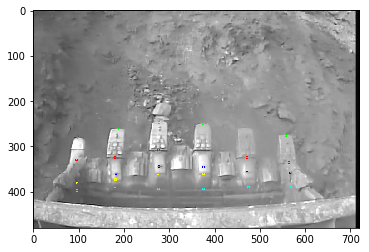

In [166]:
imagesPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/imgRegisteration/images/'
labelsPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/imgRegisteration/labels/'

file1 = '1_20161116-074000_0001n0_9767'
file2 = '1_20161116-152500_0001n0_783'

img = cv2.imread(imagesPathDir + file1 + '.png')


root = ET.parse(labelsPathDir + file1 + '_landmarkCoords.xml').getroot()

img_name = root.find('img_name').text[:-15]
toothTips = root.find('toothTip')
lipShrouds = root.find('lipShroud')
liftingEyes = root.find('liftingEye')
castLips = root.find('castLip')
bucketLandmarks = root.find('bucketLandmark')


displayPointOnImage(img, toothTips, 1)
displayPointOnImage(img, lipShrouds, 2)
displayPointOnImage(img, liftingEyes, 3)
displayPointOnImage(img, castLips, 4)
displayPointOnImage(img, bucketLandmarks, 5)


plt.imshow(img)
plt.show()

# <font color='red'> Sandbox Area (DO NOT DELETE)

In [ ]:
# (Debug) single frame of above : Fit curves to landmarks and plot them for a single frame
resultsKey = 'wmdlLogs_Pinto'
imgFileName = 'WMDL_2017.10.18_22.53.03.png'
logNb = getFrameTime(filteredResultsDict, resultsKey, imgFileName)


fittC = fitCurve2keypoints(filteredResultsDict[resultsKey][logNb], 6)

inImage = cv2.imread(wmsDir + imgFileName)

outImage =  draw_all_keypoints_boxes_andCurves(inImage, filteredResultsDict[resultsKey][logNb], fittC, 6)

plt.imshow(outImage)
plt.show()

for key in fittC.keys():
    print(key)
    print(fittC[key].deriv().deriv().c[0])

In [ ]:
# calculate the second derivative of a curve. For validation.
secondDerivative = fittC['keypoints_4'].deriv().deriv().c[0]